Исследованию зависимости процента сбоя ГПА от различных факторов. \
Описание переменных, используемых в исследовании:
- y - среднее число сбоев групп ГПА за месяц в течении года работы, группировка проведена по схожим значениям факторов;
- x1 - суммарное время, которое температура масла на входе выходила за границы интервала 65-75 ℃, необходимого для нормальной работ], в часах; 
- x2 - средняя частота вращения ротора нагнетателя в Герцах;
- x3 - кинематическая вязкость используемого масла при 50 ℃, в мм2/c;
- x4 - коэффициент технического состояния фильтрующего элемента, равный отношению перепада давления на чистом фильтре к перепаду на загрязненном фильтре при одном и том же расходе воздха.


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import scipy.stats as stats

In [26]:
%matplotlib inline
sns.set_style('darkgrid')

## Предобработка данных

In [27]:
data = pd.read_csv('gpa.csv')
y = data['y']
x = data.drop(['y'], axis=1)

[Text(0, 0.5, '')]

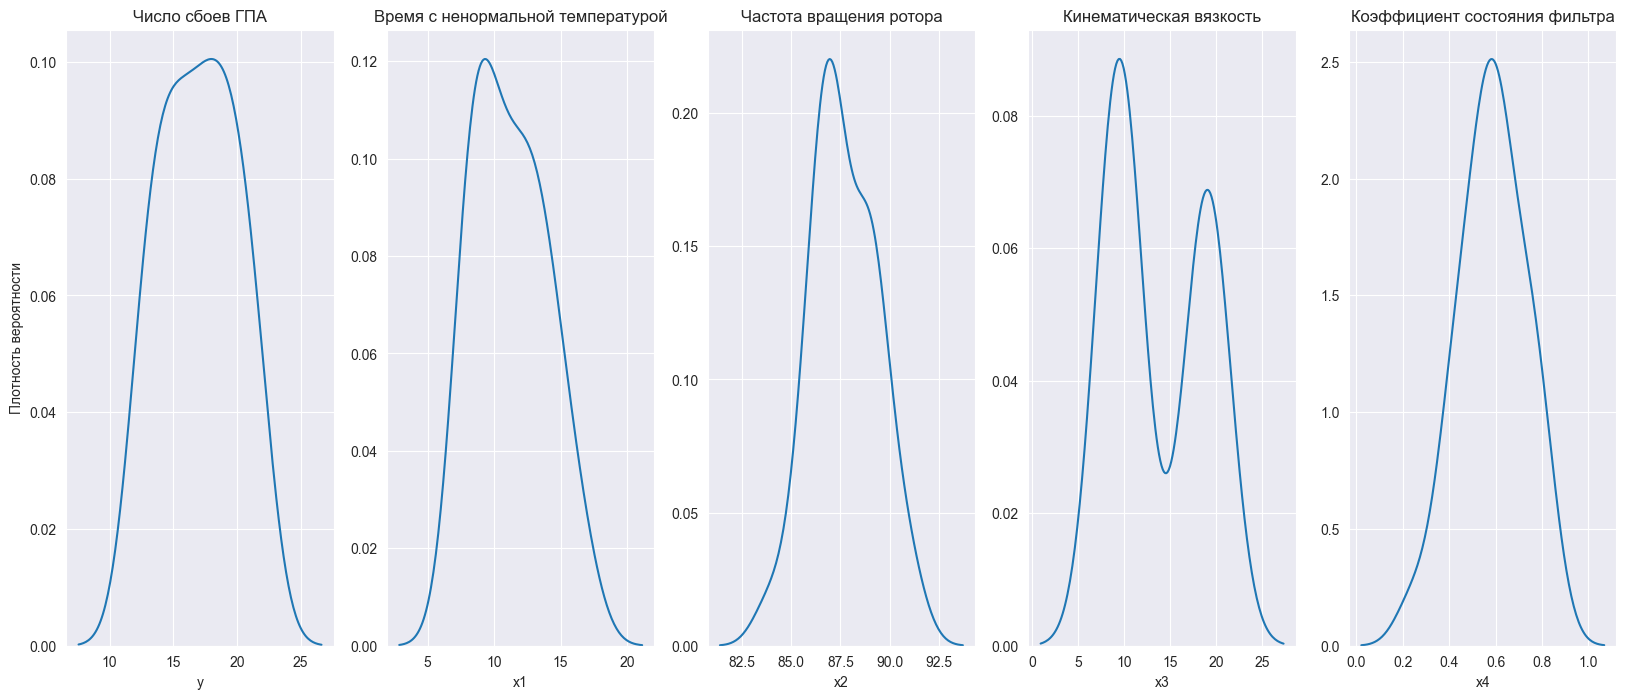

In [28]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, figsize=(20, 8))
ax0.set_title('Число сбоев ГПА')
sns.kdeplot(data['y'], ax=ax0)
ax0.set(ylabel='Плотность вероятности')
ax1.set_title('Время с ненормальной температурой')
sns.kdeplot(data['x1'], ax=ax1)
ax1.set(ylabel=None)
ax2.set_title('Частота вращения ротора')
sns.kdeplot(data['x2'], ax=ax2)
ax2.set(ylabel=None)
ax3.set_title('Кинематическая вязкость')
sns.kdeplot(data['x3'], ax=ax3)
ax3.set(ylabel=None)
ax4.set_title('Коэффициент состояния фильтра')
sns.kdeplot(data['x4'], ax=ax4)
ax4.set(ylabel=None)

## Построение модели

In [29]:
preprocessor = StandardScaler()
model = LinearRegression(n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
pipeline.fit(x, y)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', LinearRegression(n_jobs=-1))])

In [34]:
print('Уравнение регрессии:')
str = 'y =' + f' {pipeline["model"].intercept_:.3g}'
for i in range(4):
    str += f' + {pipeline["model"].coef_[i]:.3g}*x{i + 1}'
print(str)

Уравнение регрессии:
y = 17 + 1.16*x1 + 1.25*x2 + 0.158*x3 + -0.133*x4


In [35]:
factors_characteristics = pd.DataFrame(data={'mean': pipeline['preprocessor'].mean_,\
                  'var': pipeline['preprocessor'].var_}, index=['x1', 'x2', 'x3', 'x4'])
factors_characteristics.round(3)

,mean,var
x1,11.233,7.179
x2,87.690,2.666
x3,13.607,22.912
x4,0.585,0.020


Без стандартизации (для анализа коэффициентов модели и коэффициентов эластичности)

In [36]:
regressor = LinearRegression()
regressor.fit(x, y)
print('Уравнение регрессии:')
str = 'y =' + f' {regressor.intercept_:.2g}'
for i in range(4):
    str += f' + {regressor.coef_[i]:.2g}*x{i + 1}'
print(str)

Уравнение регрессии:
y = -55 + 0.43*x1 + 0.76*x2 + 0.033*x3 + -0.94*x4


## Коэффициенты эластичности

In [37]:
for i in range(4):
    print(f'Э(yx{i}) = {factors_characteristics["mean"][i] / y.mean() * regressor.coef_[i]:.3f}')

Э(yx0) = 0.286
Э(yx1) = 3.942
Э(yx2) = 0.026
Э(yx3) = -0.032


## F-значение

In [38]:
y_pred = pipeline.predict(x)
r2 = r2_score(y, y_pred)
n = 30
m = 4
f = r2 / (1 - r2) * (n - m - 1) / m
print(f'F-значение: {f:.2f}')
p_value = stats.f.sf(f, m, n - m - 1)
print(f'p-value: {p_value:.2g}')

F-значение: 12.55
p-value: 9.8e-06


## t-статистики

In [39]:
params = np.append(pipeline["model"].intercept_,pipeline["model"].coef_)

newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
MSE = (sum((y-y_pred)**2))/(n - m - 1)

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(n - m - 1))) for i in ts_b]

evaluations = pd.DataFrame(data={"Coefficient": params, "Standard Error": sd_b, "t-value": ts_b, "p-value": p_values},\
                    index=['intercept', 'x1', 'x2', 'x3', 'x4'])

print(evaluations.round(5))

           Coefficient  Standard Error  t-value  p-value
intercept     17.00667        31.71820  0.53618  0.59657
x1             1.15933         0.22044  5.25914  0.00002
x2             1.24823         0.35889  3.47800  0.00187
x3             0.15765         0.07175  2.19719  0.03749
x4            -0.13291         4.09269 -0.03247  0.97435


## Средняя относительная ошибка

In [49]:
mean_error = (abs(y - pipeline.predict(x)) / y).mean()
percentage_error = mean_error * 100
print(round(percentage_error, 3))

8.55


## Матрица парных корреляций

<Axes: >

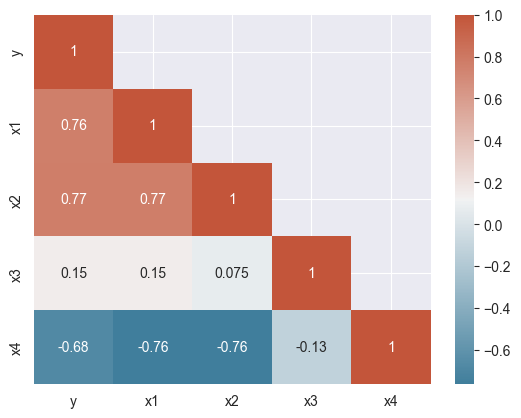

In [19]:
corr = data.corr()
mask = np.tril(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=~mask, cmap=cmap, annot=True, fmt='.2g')